In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')
# pd.set_option('display.max_rows', None)

In [2]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [3]:
# merged_ data에서 drop해야 할 단지코드
#print(train.shape, test.shape)
#train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
#test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
#print(train.shape, test.shape)

In [4]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [5]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [6]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [7]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

In [8]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수

In [9]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 38) (936, 37)


In [10]:
#train["법정동_세대수"]=(train.총인구수/train.세대당_인구)/train.총세대수
#test["법정동_세대수"]=(test.총인구수/test.세대당_인구)/test.총세대수

# 자격유형

In [11]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],
       '5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [12]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [13]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)
train= train.drop(columns="자격유형")
test= test.drop(columns="자격유형")

# 공급유형

In [14]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [15]:
train.shape, test.shape

((2577, 38), (936, 37))

# 어제 결과를 보니까 1차원으로 해야 할 것 같다.

In [16]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수',
       '공가수비율', '대형전용면적', '자격유형_카테고리'],
      dtype='object')

In [17]:
len(set(train.단지코드))

414

In [18]:
data = train.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
data = data.drop_duplicates()

In [19]:
data.shape

(414, 30)

In [20]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()

In [21]:
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1000,국민임대,566
1,C1004,영구임대,504
2,C1004,임대상가,13
3,C1005,국민임대,1144
4,C1013,국민임대,1308


In [22]:
for i in sample.공급유형.unique():
    data[str(i)]=0

In [23]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [24]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1000,121064.285714,1.320357e+07
1,C1004,877964.187248,1.038396e+07
2,C1005,222046.666667,1.710767e+07
3,C1013,134726.000000,2.492480e+07
4,C1014,160488.571429,2.389400e+07


In [25]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = data[data['단지코드']==code].index
    data.loc[ind,'임대료'] = val1
    data.loc[ind,'임대보증금'] = val2

In [26]:
sample = pd.DataFrame(train.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1000,1,566
1,C1004,2,504
2,C1004,7,13
3,C1005,1,1144
4,C1013,1,1308


In [27]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = data[data['단지코드']==code].index
    data.loc[ind,col] = val

In [28]:
data=data.fillna(0)

In [29]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1000,0
1,C1004,1
2,C1005,0
3,C1013,0
4,C1014,0


In [30]:
data=pd.merge(data, sample, on="단지코드", how="inner")

# Test에 똑같이

In [31]:
print(len(set(test.단지코드)))
dat = test.drop(columns=['공급유형','자격유형_카테고리','전용면적','임대건물구분',
                           '전용면적별세대수','대형전용면적','자격유형_카테고리',
                           '임대보증금','임대료'])
dat = dat.drop_duplicates()
dat.shape

147


(147, 29)

In [32]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,공급유형,전용면적별세대수
0,C1003,행복주택,480
1,C1006,영구임대,1475
2,C1006,임대상가,13
3,C1016,국민임대,643
4,C1019,국민임대,321


In [33]:
for i in sample.공급유형.unique():
    dat[str(i)]=0

In [34]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [35]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
sample.head()

,단지코드,임대료,임대보증금
0,C1003,1.158750e+05,2.265000e+07
1,C1006,2.333169e+06,1.754953e+07
2,C1016,2.280100e+05,2.402675e+07
3,C1019,1.264300e+05,1.485750e+07
4,C1030,2.142167e+05,5.141333e+07


In [36]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val1 = sample.loc[i,'임대료']
    val2 = sample.loc[i,'임대보증금']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,'임대료'] = val1
    dat.loc[ind,'임대보증금'] = val2

In [37]:
sample = pd.DataFrame(test.groupby(['단지코드','자격유형_카테고리']).sum()['전용면적별세대수']).reset_index()
sample.head()

,단지코드,자격유형_카테고리,전용면적별세대수
0,C1003,4,480
1,C1006,2,1459
2,C1006,7,29
3,C1016,1,643
4,C1019,1,321


In [38]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'자격유형_카테고리']
    val = sample.loc[i,'전용면적별세대수']
    ind = dat[dat['단지코드']==code].index
    dat.loc[ind,col] = val

In [39]:
dat=dat.fillna(0)

In [40]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
sample.head()

,단지코드,대형전용면적
0,C1003,0
1,C1006,1
2,C1016,0
3,C1019,0
4,C1030,0


In [41]:
dat=pd.merge(dat, sample, on="단지코드", how="inner")

In [43]:
dat.columns=[       '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',         '단지명',
             '도로명주소',         '연면적',          '위도',          '경도',
       'subway_name', 'subway_dist',       '환승역 수',        '총인구수',
            '세대당_인구',       '남/여비율',   '남/여_0~19세',  '남/여_20~39세',
        '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',   '20~39세_비율',
         '40~69세_비율',    '70세이상_비율',    '상가비율',  '세대당_가능주차면수',
             '공가수비율',        '행복주택',        '영구임대',        '임대상가',
              '국민임대',   '공공임대(50년)',    '공공임대(단기)',    '공공임대(분납)',
               '임대료',       '임대보증금',             '자격유형4',             '자격유형2',
                   '자격유형7',             '자격유형1',             '자격유형6',             '자격유형3',
                   '자격유형5',      '대형전용면적']
data.columns=[  '단지코드',        '총세대수',          '지역',         '공가수',
              '지하철역',       '버스정류장',     '단지내주차면수',       '등록차량수',
               '단지명',       '도로명주소',         '연면적',          '위도',
                '경도', 'subway_name', 'subway_dist',       '환승역 수',
              '총인구수',      '세대당_인구',       '남/여비율',   '남/여_0~19세',
        '남/여_20~39세',  '남/여_40~69세',   '남/여_70세이상',    '0~19세_비율',
         '20~39세_비율',   '40~69세_비율',    '70세이상_비율',  '상가비율',
        '세대당_가능주차면수',       '공가수비율',        '국민임대',        '영구임대',
              '임대상가',    '공공임대(단기)',    '장기전세',       '행복주택',
          '공공임대(분납)',        '공공분양',   '공공임대(50년)',         '임대료',
             '임대보증금', '자격유형1',  '자격유형2',             '자격유형7',
                   '자격유형3', '자격유형6','자격유형4','자격유형5',
            '대형전용면적']

# 지역 카테고리 추가 & 지역 drop

In [44]:
#group1 = ['대구광역시','세종특별자치시','경기도','서울특별시','충청북도','전라남도','전라북도','경상북도']
#group2 = ['대전광역시','울산광역시','광주광역시','경상남도','제주특별자치도','부산광역시','충청남도','강원도']    
#data.loc[data.지역.isin(group1),"지역_카테고리"] = "high"
#data.loc[data.지역.isin(group2),"지역_카테고리"] = "low"
#dat.loc[dat.지역.isin(group1),"지역_카테고리"] = "high"
#dat.loc[dat.지역.isin(group2),"지역_카테고리"] = "low"

# 임대료, 임대보증금 std

In [45]:
#sample1=pd.DataFrame(train.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(train.groupby("단지코드")["임대보증금"].std()).reset_index()
#data=pd.merge(data, sample1, on="단지코드", how="inner")
#data=pd.merge(data, sample2, on="단지코드", how="inner")
#sample1=pd.DataFrame(test.groupby("단지코드")["임대료"].std()).reset_index()
#sample2=pd.DataFrame(test.groupby("단지코드")["임대보증금"].std()).reset_index()
#dat=pd.merge(dat, sample1, on="단지코드", how="inner")
#dat=pd.merge(dat, sample2, on="단지코드", how="inner")

# Correlation 확인

In [44]:
X_cor = data.drop(columns=['단지코드','단지명','도로명주소','subway_name', "지역"])

In [45]:
X_cor = pd.get_dummies(X_cor, drop_first=True)

In [ ]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from statsmodels.api import OLS

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()
#standardScaler.fit(X_train)
#X_train = standardScaler.transform(X_train)
#standardScaler.fit(X_test)
#X_test = standardScaler.transform(X_test)

# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error

## 나눠서 modeling

In [ ]:
pd.concat([pd.DataFrame(data.단지내주차면수.describe()),
           pd.DataFrame(dat.단지내주차면수.describe())], axis=1)

In [ ]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [ ]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

In [ ]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
        best_tst_pred = sum(best_tst_pred,[])
        best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [ ]:
models = [LinearRegression(), 
          PLSRegression(), 
          Ridge(random_state=2021),
          Lasso(random_state=2021), 
          ElasticNet(random_state=2021),
          #SVR(),
          CatBoostRegressor(random_state=2021, loss_function = 'MAE'),
          RandomForestRegressor(criterion="mae",random_state=2021),
          GradientBoostingRegressor(criterion="mae",random_state=2021),
          XGBRegressor(random_state=2021)]

In [ ]:
X1 = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가", "자격유형2"])
X1 = pd.get_dummies(X1, drop_first=True)
y1=train1["등록차량수"]

In [ ]:
best_model1, best_tst_pred1, best_error1 = fit_models(X1, y1, models, cv=True)

In [ ]:
#best_tst_pred1

In [ ]:
X2=train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가","자격유형2"])
X2 = pd.get_dummies(X2, drop_first=True)
y2=train2["등록차량수"]

In [ ]:
best_model2, best_tst_pred2, best_error2=fit_models(X2, y2, models, cv=True)

In [ ]:
#best_model2, best_tst_pred2, best_error2

In [ ]:
X1 = train1.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가",
                           "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"
                         ])
X1 = pd.get_dummies(X1, drop_first=True)
y1=train1["등록차량수"]

In [ ]:
best_model_1, best_tst_pred_1, best_error_1 = fit_models(X1, y1, models, cv=True)

In [ ]:
#best_tst_pred_1

In [ ]:
X2=train2.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가",
                       "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])
X2 = pd.get_dummies(X2, drop_first=True)
y2=train2["등록차량수"]

In [ ]:
best_model_2, best_tst_pred_2, best_error_2=fit_models(X2, y2, models, cv=True)

In [ ]:
#best_tst_pred_2

In [ ]:
기존=pd.merge(pd.DataFrame(best_tst_pred1,index=[0]).T.reset_index(),
         pd.DataFrame(train1.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

In [ ]:
자격유형드랍=pd.merge(pd.DataFrame(best_tst_pred_1,index=[0]).T.reset_index(),
         pd.DataFrame(train1.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

In [ ]:
df=pd.merge(기존, 자격유형드랍, on="단지코드", how='inner')

In [ ]:
df.columns

In [ ]:
df=df.drop(columns=["index_x", "index_y"])

In [ ]:
df=pd.merge(df, train1[["단지코드", "등록차량수"]], on="단지코드", how="inner")

In [ ]:
df.columns=['pred_기본', '단지코드', 'pred_자격유형x', 'real_Y']

In [ ]:
df=df[['단지코드', 'pred_기본', 'pred_자격유형x', 'real_Y']]

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
#df

In [ ]:
df["diff"]=abs(df.pred_기본-df.pred_자격유형x)

In [ ]:
#df.sort_values("diff")

In [ ]:
#train1[train1.상가비율>=0.7][["단지코드", "지역", "등록차량수", "단지내주차면수", "총세대수"]]

In [ ]:
#train[train.단지코드=="C1616"][["단지코드","총세대수", "단지내주차면수", "등록차량수", "세대당_인구", "상가비율"]]

In [ ]:
기존=pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train2.단지코드.reset_index(drop=True)).reset_index(),
         on="index")
자격유형드랍=pd.merge(pd.DataFrame(best_tst_pred_2,index=[0]).T.reset_index(),
         pd.DataFrame(train2.단지코드.reset_index(drop=True)).reset_index(),
         on="index")

df2=pd.merge(기존, 자격유형드랍, on="단지코드", how='inner')
df2=df2.drop(columns=["index_x", "index_y"])

df2=pd.merge(df2, train2[["단지코드", "등록차량수"]], on="단지코드", how="inner")
df2.columns=['pred_기본', '단지코드', 'pred_자격유형x', 'real_Y']
df2=df2[['단지코드', 'pred_기본', 'pred_자격유형x', 'real_Y']]

In [ ]:
#df2

In [ ]:
df2["diff"]=abs(df2.pred_기본-df2.pred_자격유형x)

In [ ]:
df2.sort_values("diff")

In [ ]:
print(best_error1, best_error_1)
print(best_error2, best_error_2)

In [ ]:
#df.to_csv("785미만.csv", index=False)
#df2.to_csv("785이상.csv", index=False)

# 나눠서 예측

In [45]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [46]:
sample.shape

(150, 2)

In [47]:
train1=data[data.단지내주차면수<785]
train2=data[data.단지내주차면수>=785]
test1=dat[dat.단지내주차면수<785]
test2=dat[dat.단지내주차면수>=785]

In [48]:
#train1=data[data.세대당_가능주차면수<0.8304195804195804]
#train2=data[data.세대당_가능주차면수>=0.8304195804195804]
#test1=dat[dat.세대당_가능주차면수<0.8304195804195804]
#test2=dat[dat.세대당_가능주차면수>=0.8304195804195804]

In [49]:
print(train1.shape, train2.shape)
print(test1.shape, test2.shape)

(310, 48) (104, 48)
(113, 46) (34, 46)


In [50]:
df= pd.concat([train1, test1])

In [51]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가", 
                     "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])
X = pd.get_dummies(X, drop_first=True)

In [52]:
X_train1=X.iloc[0:310, :]
X_test1=X.iloc[310:, :]
y_train1 = train1[['등록차량수']]

In [53]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [54]:
model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train1, y_train1)
model1_pred = model_1.predict(X_test1)

In [55]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [56]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1.head()

,code,num
0,C1072,751.283215
1,C1456,558.946677
2,C1840,533.430406
3,C1640,449.971614
4,C1377,369.108621


In [57]:
df= pd.concat([train2, test2])

In [58]:
X = df.drop(columns=['단지명','단지코드','도로명주소','subway_name',
                         '등록차량수', "임대상가",
                    "자격유형1","자격유형2","자격유형3","자격유형4","자격유형5","자격유형6","자격유형7"])
X = pd.get_dummies(X, drop_first=True)

In [59]:
X_train2=X.iloc[0:104, :]
X_test2=X.iloc[104:, :]
y_train2 = train2[['등록차량수']]

In [60]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [61]:
model_2= CatBoostRegressor(random_state=2021, verbose=False).fit(X_train2, y_train2)
model2_pred = model_2.predict(X_test2)

In [62]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [63]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2.head()

,code,num
0,C1128,1231.466058
1,C1332,1207.465486
2,C1563,1765.614415
3,C1794,922.645080
4,C2411,792.536026


In [64]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2], axis=0))
df_merge=df_merge.reset_index(drop=True)

In [65]:
df_merge.head()

,code,num
0,C1072,751.283215
1,C1456,558.946677
2,C1840,533.430406
3,C1640,449.971614
4,C1377,369.108621


In [66]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [67]:
test_split.head()

,code,num_x,num_y
0,C1072,0,751.283215
1,C1128,0,1231.466058
2,C1456,0,558.946677
3,C1840,0,533.430406
4,C1332,0,1207.465486


In [68]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [69]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [70]:
test_split

,code,num
0,C1072,751.283215
1,C1128,1231.466058
2,C1456,558.946677
3,C1840,533.430406
4,C1332,1207.465486
...,...,...
145,C2456,253.544787
146,C1266,507.431829
147,C2152,122.343166
148,C1267,361.364943


In [77]:
one=pd.read_csv("0719_1.csv")
one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]
test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]
mean_absolute_error(one.num, test_.num)

17.180649076985585

Text(0.5, 0, 'CatBoost1 Feature Importance')

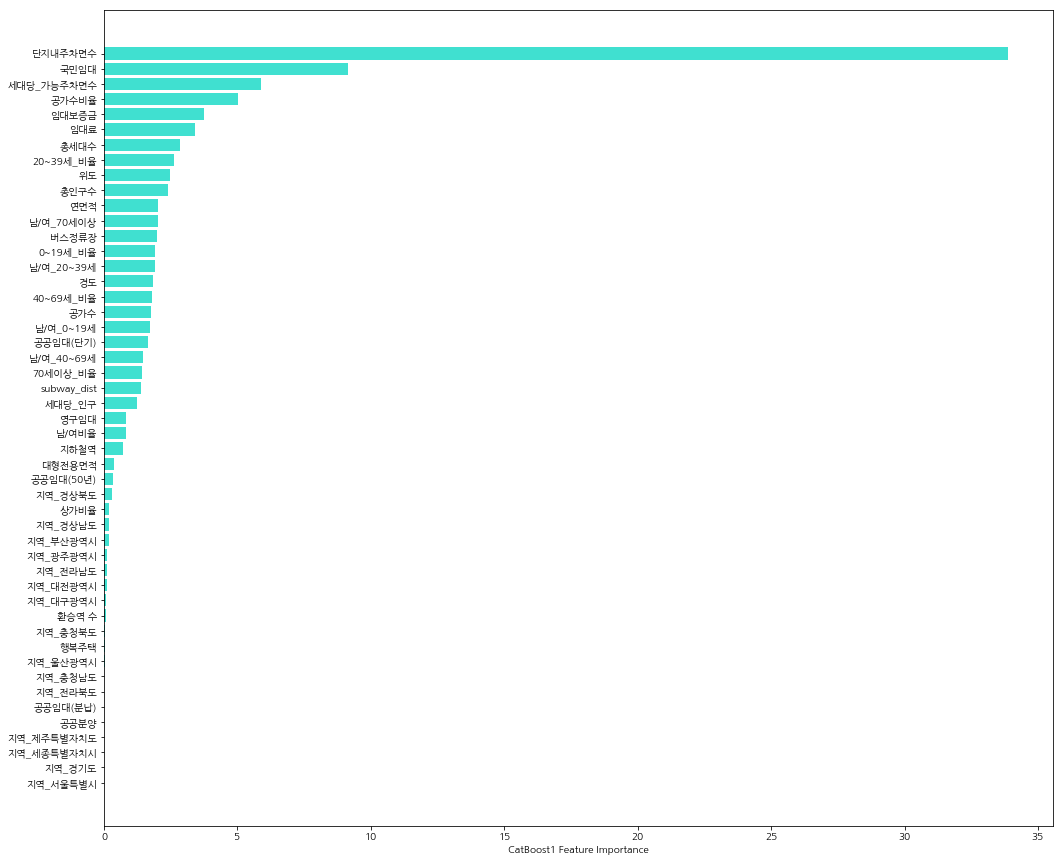

In [72]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X_test1.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost1 Feature Importance")

Text(0.5, 0, 'CatBoost2 Feature Importance')

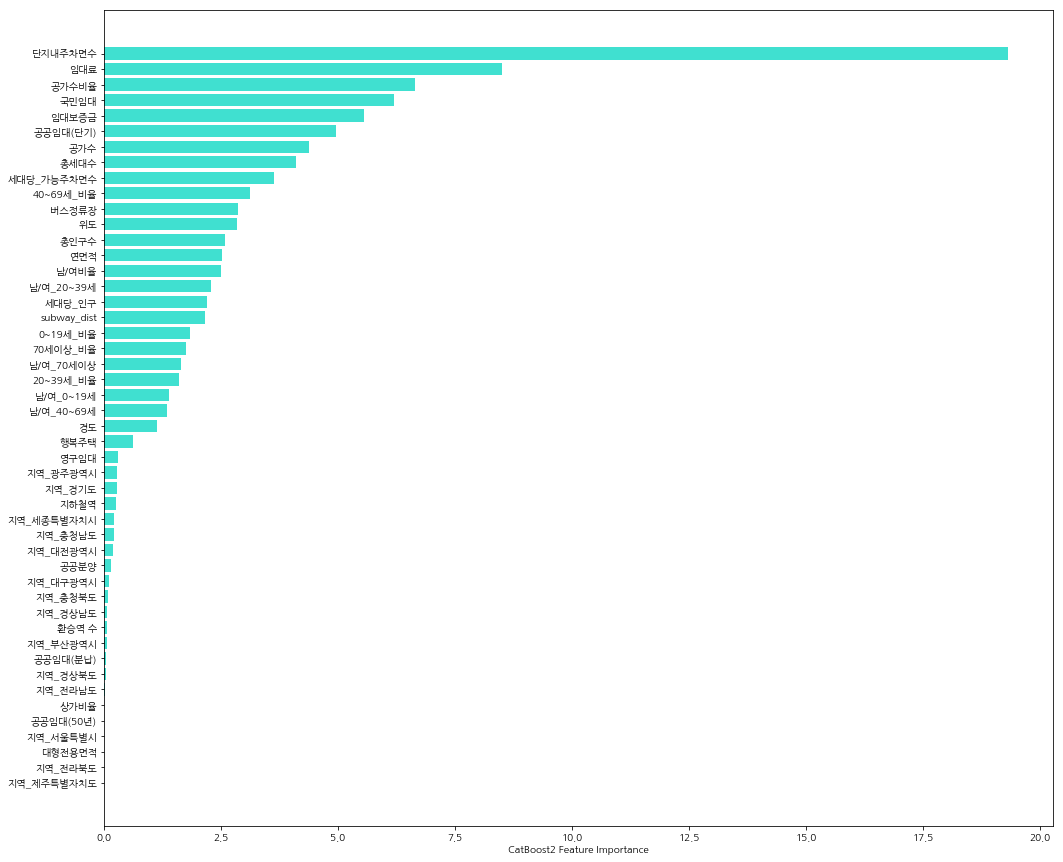

In [73]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_2.feature_importances_.argsort()
plt.barh(X_test2.columns[sorted_feature_importance], 
        model_2.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost2 Feature Importance")

In [75]:
#test_split.to_csv('0719_jang.csv', index=False)